# Design point comparative workflow¶
This example shows how to start PyEnSight on Ansys Lab, and load and compare two Fluent solutions of the mixing elbow dataset, which is common in piping systems in power plants and process industries. Comparing the temperature from these two solutions in terms of a difference field in the area of the mixing region is an important step towards choosing the optimal design.

This example uses the guided workflow to set up the comparison, to show an example of deep pixel rendering, which allows an interactive, quantitative view of the temperature differences in the two solutions.

This example also shows a remote rendering session, allowing interactive manipulation of the resulting difference geometry for better insight and understanding.

***Workflow tasks***

Reading the design point from a remote S3 bucket.<br>
Setting up the display using multiple viewports.<br>
Doing a difference calculation using the EnSight calculator.<br>
Showing a deep pixel rendering for interative spatial view of the differences pixel by pixel.<br>
Showing a remote rendering to allow interactive geometry rotation, zooming, and panning.<br>


In [1]:
!pip install ansys_pyensight_core

## Start an EnSight session
Launch and connect to an instance of EnSight.

An EnSight Container is launched on Ansys Lab using launch_ensight(). Optional arguments can be specified to launch_ensight() such as to use EnSight SoS or enable the EnSight REST API.
Currently, the EnSight Docker Image is rather large.  Starting it the first time in a Notebook may take a minute or two while the Image is downloaded.


In [1]:
from ansys.pyensight.core import launch_ensight
session = launch_ensight()

CEI_HOME= /ansys_inc/v241/CEI
Ansys Version= 241


## Load the data
Load the two datasets into two separate cases. This data is Fluent data, downloaded from an S3 Bucket which contains the EnSight examples. Downloading the data can take a minute or more. Note the names of the parts that are loaded. At initial load, both cases and their parts are shown overlaid on each other.
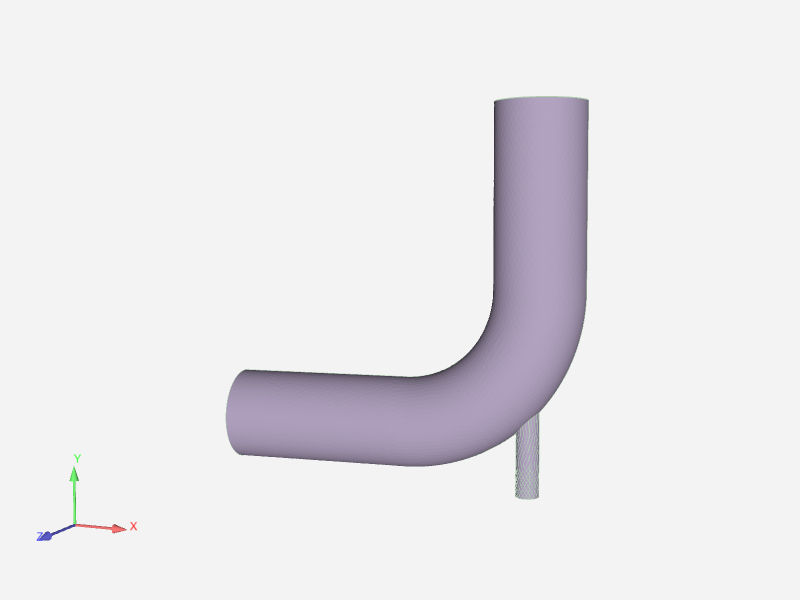

In [2]:
session.load_example("elbow_dp0_dp1.ens")
session.show("image", width=800, height=600)
print([p.PATHNAME for p in session.ensight.objs.core.PARTS])

['Case 1|fluid', 'Case 1|wall-fluid', 'Case 1|velocity-inlet-large', 'Case 1|velocity-inlet-small', 'Case 1|pressure-outlet', 'Case 1|symmetry', 'Case 2|fluid', 'Case 2|wall-fluid', 'Case 2|velocity-inlet-large', 'Case 2|velocity-inlet-small', 'Case 2|pressure-outlet', 'Case 2|symmetry']


## Create a trio of viewports
We need to show the parts separately, each in a viewport window, as well as a third viewport on the lower half of the window, for the difference field.
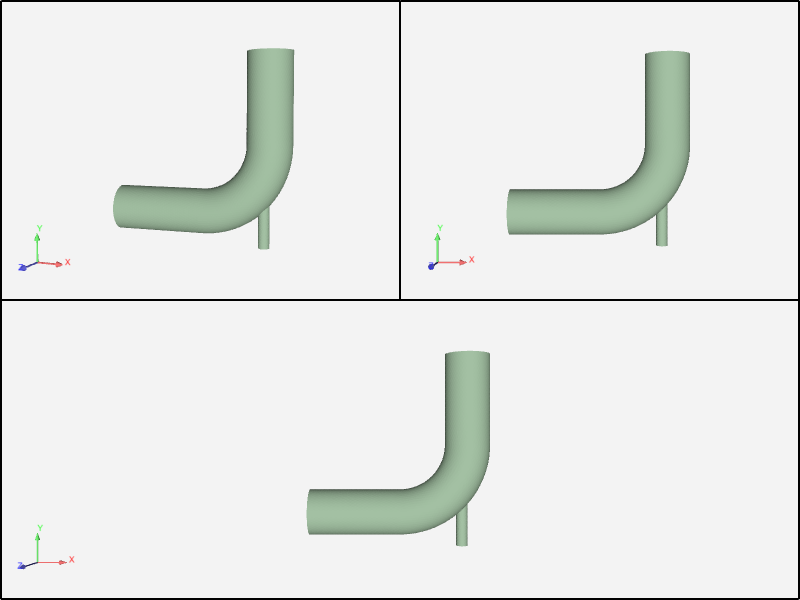

In [ ]:
# Create two more viewports. (There is always one viewport.)
session.ensight.objs.core.DEFAULTVPORT[0].createviewport()
session.ensight.objs.core.DEFAULTVPORT[0].createviewport()
# Make these viewports visible and grab references to the viewport objects.
session.ensight.objs.core.VPORTS.set_attr(session.ensight.objs.enums.VISIBLE, True)
vp0 = session.ensight.objs.core.VPORTS[0]
vp1 = session.ensight.objs.core.VPORTS[1]
vp2 = session.ensight.objs.core.VPORTS[2]
# Position the viewports by setting their WIDTH, HEIGHT, ORIGINX, and ORIGINY attributes.
vp0.WIDTH = 0.5
vp1.WIDTH = 0.5
vp2.WIDTH = 1.0
session.ensight.objs.core.VPORTS.set_attr(session.ensight.objs.enums.HEIGHT, 0.5)
vp0.ORIGINX = 0.0
vp0.ORIGINY = 0.5
vp0.BORDERVISIBLE = True
vp1.ORIGINX = 0.5
vp1.ORIGINY = 0.5
vp2.ORIGINX = 0.0
vp2.ORIGINY = 0.0
# Link the transforms of all the viewports to each other.
session.ensight.objs.core.VPORTS.set_attr(session.ensight.objs.enums.LINKED, True)
# Hide all but the "fluid" parts
session.ensight.objs.core.PARTS.set_attr(session.ensight.objs.enums.VISIBLE, False)
session.ensight.objs.core.PARTS["fluid"].set_attr(session.ensight.objs.enums.VISIBLE, True)
session.ensight.objs.core.PARTS["fluid"].set_attr(
    session.ensight.objs.enums.ELTREPRESENTATION, session.ensight.objs.enums.BORD_FULL
)
session.show("image", width=800, height=600)

## Color and assign parts to specific viewports
This code colors the “fluid” parts using the ***Static_Temperature*** variable and assigns specific parts to specific viewports. It then loads the dataset-created fluid parts for both loaded cases.

Because another part is needed to display the temperature difference variable in the lower pane, the code uses the ***LPART*** (part loader part) to create a second instance of the fluid part in the first case. The code then computes the difference field on this part to make it easier to display all three at the same time.
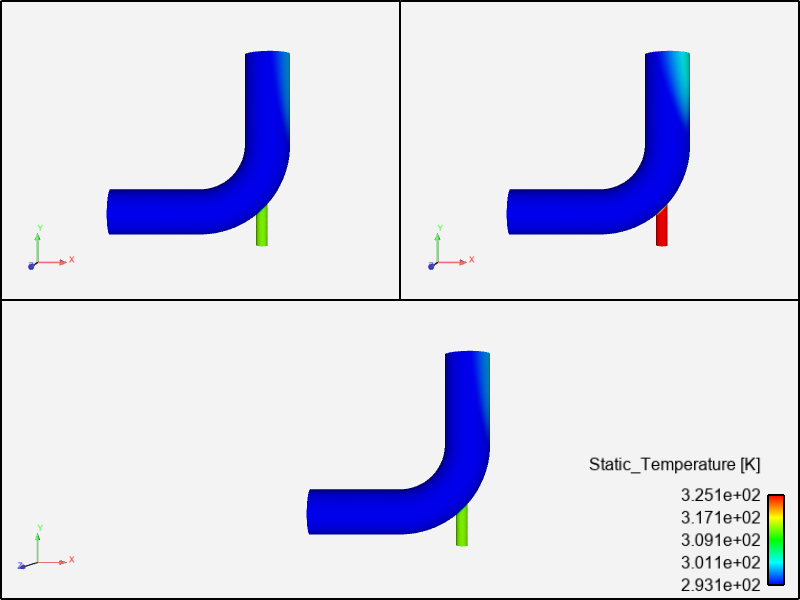

In [ ]:
fluid0 = session.ensight.objs.core.PARTS["fluid"][0]
fluid1 = session.ensight.objs.core.PARTS["fluid"][1]

# Using ``LPART``, find the ``ENS_LPART`` instance in the first case
# for the part named "fluid".  Load this object to get a
# new instance of the case 0 "fluid" mesh.
fluid0_diff = session.ensight.objs.core.CASES[0].LPARTS.find("fluid")[0].load()
fluid0_diff.ELTREPRESENTATION = session.ensight.objs.enums.BORD_FULL

# Get the temperature variable and color the fluid parts by it.
temperature = session.ensight.objs.core.VARIABLES["Static_Temperature"][0]
fluid0_diff.COLORBYPALETTE = temperature
fluid0.COLORBYPALETTE = temperature
fluid1.COLORBYPALETTE = temperature

# Each of the three parts should only be visible in one viewport.
fluid0.VIEWPORTVIS = session.ensight.objs.enums.VIEWPORT00
fluid1.VIEWPORTVIS = session.ensight.objs.enums.VIEWPORT01
fluid0_diff.VIEWPORTVIS = session.ensight.objs.enums.VIEWPORT02
session.show("image", width=800, height=600)

## Compute difference field
Use the ***CaseMapDiff*** calculator function to compute the difference between the ***Static_Temperature*** fields between the two design points. This defines a new field, ***Temperature_Difference***, on the ***fluid0_diff*** part. Color that part by the resulting difference variable using deep pixel rendering.

## Deep Pixel Rendering
Deep pixel rendering allows you to 'hover' over the geometry and have the actual variable value displayed at the pixel location of your mouse. Try hovering over the bottom viewport geometry to see the difference variable values.
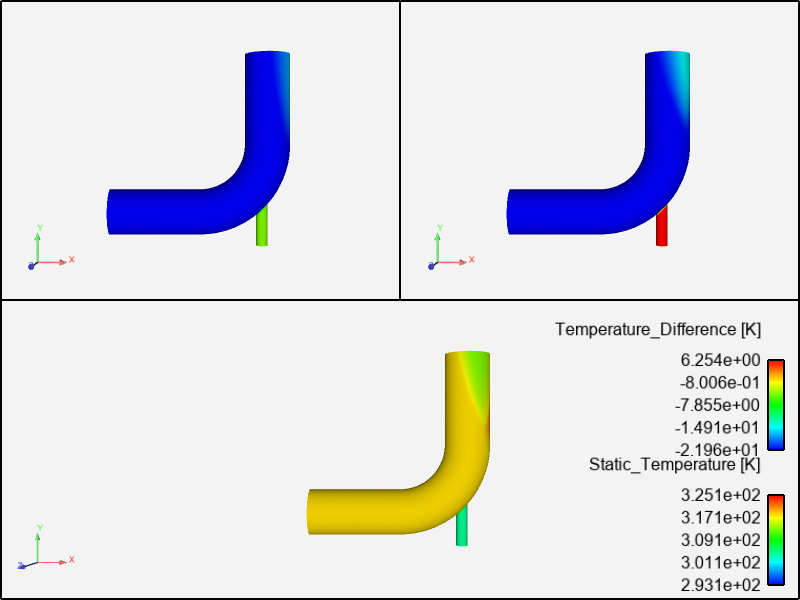

In [ ]:
temperature_diff = session.ensight.objs.core.create_variable(
    "Temperature_Difference",
    value="CaseMapDiff(plist, 2, Static_Temperature, 0, 1)",
    sources=[fluid0_diff],
)

fluid0_diff.COLORBYPALETTE = temperature_diff

# Adjust legend location for upper two viewports for clarity
session.ensight.legend.select_palette_begin("Static_Temperature")
session.ensight.legend.visible("ON")
session.ensight.legend.location_x(0.66)
session.ensight.legend.location_y(0.75)

session.show("deep_pixel", width=800, height=600)

## Adjust palette limits
To make the visualization a bit easier to interpret, adjust the ***Temperature_Difference*** palette limits to the nearest factor of five. Let's also make the session into a ***remote*** session to directly display the EnSight rendering window, to enable us to rotate, translate and pan the view as desired interactively.
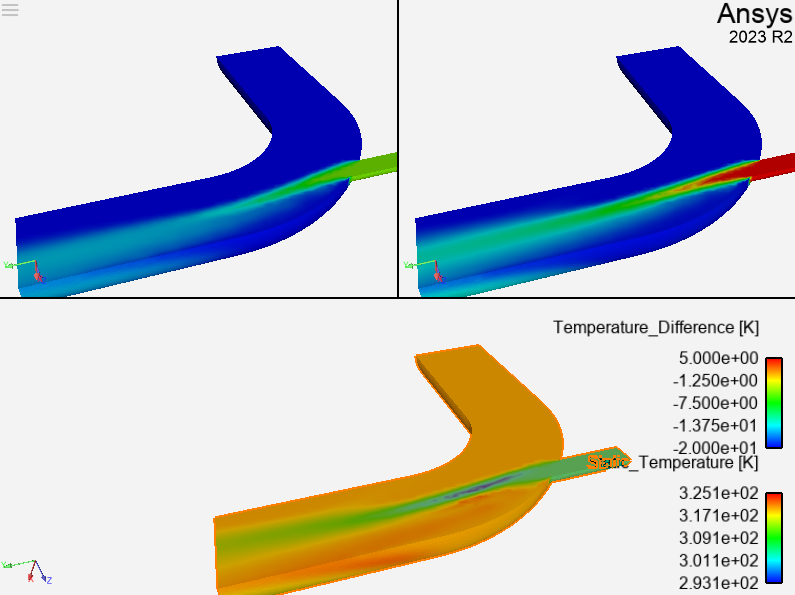

In [ ]:
limits = [(round(v / 5.0) * 5) for v in temperature_diff.MINMAX]
temperature_diff.PALETTE[0].MINMAX = limits
remote = session.show("remote")

## Finished! Now close the EnSight session

In [ ]:
session.close()